In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
# display.set_matplotlib_formats('svg')

In [18]:
data = pd.read_feather('./data/house_sales.ftr')

In [19]:
data.shape

(164944, 1789)

In [20]:
data.head(2)

,Id,Address,Sold Price,Sold On,Summary,Type,Year built,Heating,Cooling,Parking,...,Well Disclosure,remodeled,DOH2,SerialX,Full Baths,Tax Legal Lot Number,Tax Legal Block Number,Tax Legal Tract Number,Building Name,Zip
0,2080183300,"11205 Monterey,","$2,000,000",01/31/20,"11205 Monterey, San Martin, CA 95046 is a sing...",SingleFamily,No Data,No Data,No Data,0 spaces,...,None,None,None,None,None,None,None,None,None,95046
1,20926300,"5281 Castle Rd,","$2,100,000",02/25/21,Spectacular Mountain and incredible L.A. City ...,SingleFamily,1951,Central,"Central Air, Dual","Driveway, Driveway - Brick",...,None,None,None,None,None,None,None,None,None,91011


In [21]:
null_sum = data.isnull().sum()
data.columns[null_sum < len(data) * 0.3]  # columns will keep

Index(['Id', 'Address', 'Sold Price', 'Sold On', 'Summary', 'Type',
       'Year built', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Home type', 'Region', 'Elementary School', 'Elementary School Score',
       'Elementary School Distance', 'High School', 'High School Score',
       'High School Distance', 'Heating features', 'Parking features',
       'Lot size', 'Parcel number', 'Tax assessed value', 'Annual tax amount',
       'Listed On', 'Listed Price', 'Zip'],
      dtype='object')

In [22]:
null_sum.head()

Id               0
Address          0
Sold Price      85
Sold On          0
Summary       3117
dtype: int64

In [23]:
data.drop(columns=data.columns[null_sum > len(data) * 0.3], inplace=True)

In [24]:
data.shape

(164944, 32)

In [25]:
data.dtypes

Id                             object
Address                        object
Sold Price                     object
Sold On                        object
Summary                        object
Type                           object
Year built                     object
Heating                        object
Cooling                        object
Parking                        object
Bedrooms                       object
Bathrooms                      object
Total interior livable area    object
Total spaces                   object
Garage spaces                  object
Home type                      object
Region                         object
Elementary School              object
Elementary School Score        object
Elementary School Distance     object
High School                    object
High School Score              object
High School Distance           object
Heating features               object
Parking features               object
Lot size                       object
Parcel numbe

In [26]:
currency = ['Sold Price', 'Listed Price', 'Tax assessed value', 'Annual tax amount']
for c in currency:
    data[c] = data[c].replace(
        r'[$,-]', '', regex=True).replace(
        r'^\s*$', np.nan, regex=True).astype(float)

In [27]:
areas = ['Total interior livable area', 'Lot size']
for c in areas:
    acres = data[c].str.contains('Acres') == True
    col = data[c].replace(r'\b sqft\b|\b Acres\b|\b,\b','', regex=True).astype(float)
    col[acres] *= 43560
    data[c] = col

In [28]:
data.describe()

,Sold Price,Total interior livable area,Lot size,Tax assessed value,Annual tax amount,Listed Price
count,1.648590e+05,1.465450e+05,1.358450e+05,1.450650e+05,1.433500e+05,1.250060e+05
mean,1.194842e+06,3.182221e+03,9.525061e+05,8.898781e+05,1.123415e+04,1.197671e+06
std,3.336365e+06,4.609881e+05,1.357197e+08,3.126888e+06,3.859389e+04,2.874721e+06
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,4.350000e+05,1.170000e+03,4.800000e+03,2.550000e+05,3.434250e+03,4.990000e+05
50%,8.050000e+05,1.558000e+03,6.603000e+03,5.635010e+05,7.372000e+03,8.490000e+05
75%,1.370000e+06,2.144000e+03,1.209000e+04,1.033832e+06,1.321300e+04,1.395000e+06
max,8.660000e+08,1.764164e+08,4.856770e+10,8.256328e+08,9.977342e+06,6.250000e+08


In [29]:
abnormal = (data[areas[1]] < 10) | (data[areas[1]] > 1e4)
data = data[~abnormal]
sum(abnormal)

41000

(123944,)

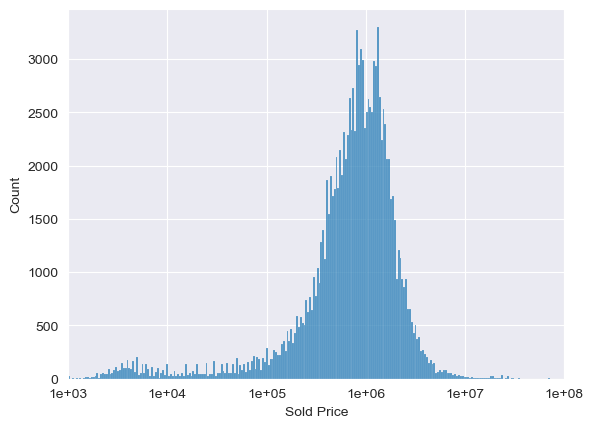

In [32]:
ax = sns.histplot(np.log10(data['Sold Price']))
ax.set_xlim([3, 8])
ax.set_xticks(range(3, 9))
ax.set_xticklabels(['%.0e'%a for a in 10**ax.get_xticks()])
np.log10(data['Sold Price']).shape

In [33]:
data['Type'].value_counts()[0:20]

Type
SingleFamily            74318
Condo                   18749
MultiFamily              6586
VacantLand               6199
Townhouse                5846
Unknown                  5390
MobileManufactured       2588
Apartment                1416
Cooperative               161
Residential Lot            75
Single Family              69
Single Family Lot          56
Acreage                    48
2 Story                    39
3 Story                    25
Hi-Rise (9+), Luxury       21
RESIDENTIAL                19
Duplex                     19
Condominium                19
Mid-Rise (4-8)             17
Name: count, dtype: int64

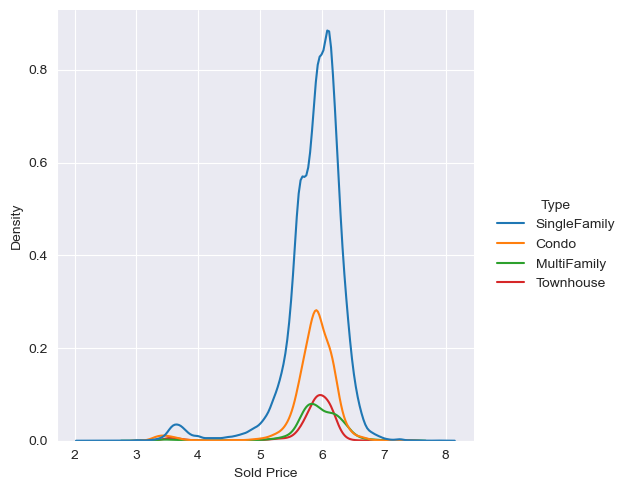

In [34]:
types = data['Type'].isin(['SingleFamily', 'Condo', 'MultiFamily', 'Townhouse'])
sns.displot(pd.DataFrame({'Sold Price':np.log10(data[types]['Sold Price']),
                          'Type':data[types]['Type']}),
            x='Sold Price', hue='Type', kind='kde')

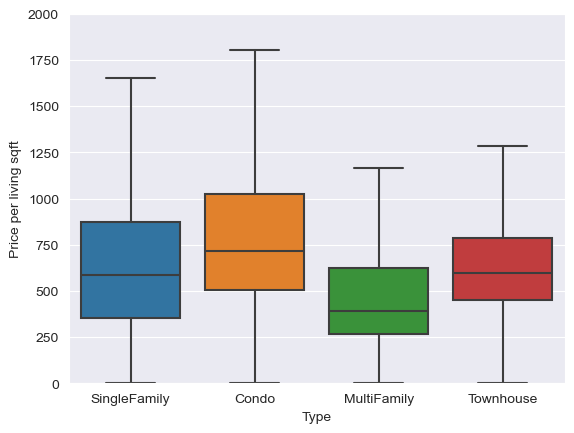

In [35]:
data['Price per living sqft'] = data['Sold Price'] / data['Total interior livable area']
ax = sns.boxplot(x='Type', y='Price per living sqft', data=data[types], fliersize=0)
ax.set_ylim([0, 2000])

[Text(0, 0, '95118'),
 Text(1, 0, '94043'),
 Text(2, 0, '95131'),
 Text(3, 0, '94110'),
 Text(4, 0, '94123'),
 Text(5, 0, '90003'),
 Text(6, 0, '94114'),
 Text(7, 0, '95123'),
 Text(8, 0, '94118'),
 Text(9, 0, '94122'),
 Text(10, 0, '95122'),
 Text(11, 0, '94103'),
 Text(12, 0, '90011'),
 Text(13, 0, '94117'),
 Text(14, 0, '94089'),
 Text(15, 0, '94112'),
 Text(16, 0, '94131'),
 Text(17, 0, '94115'),
 Text(18, 0, '94121'),
 Text(19, 0, '94116')]

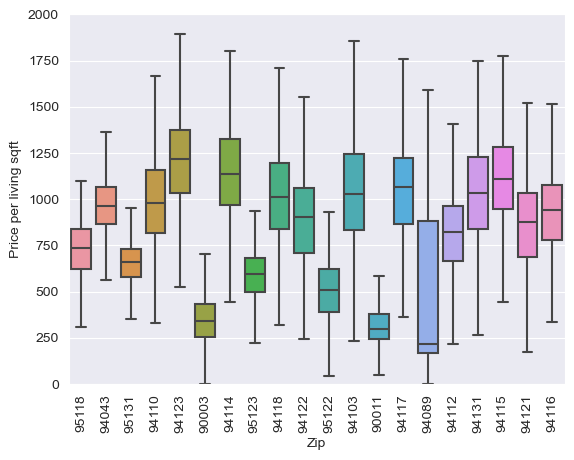

In [36]:
d = data[data['Zip'].isin(data['Zip'].value_counts()[:20].keys())]
ax = sns.boxplot(x='Zip', y='Price per living sqft', data=d, fliersize=0)
ax.set_ylim([0, 2000])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<Axes: >

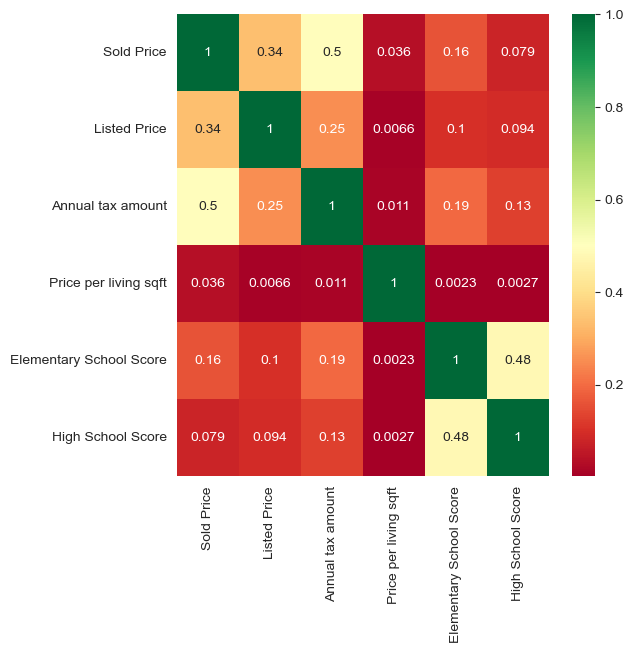

In [37]:
_, ax = plt.subplots(figsize=(6,6))
columns = ['Sold Price', 'Listed Price', 'Annual tax amount', 'Price per living sqft', 'Elementary School Score', 'High School Score']
sns.heatmap(data[columns].corr(),annot=True,cmap='RdYlGn', ax=ax)